In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
from random import shuffle
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

import warnings
warnings.filterwarnings('ignore')

seed = 7
np.random.seed(seed)

import sys
sys.path.insert(0, '../python/')
import util
import mlflow
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
import time

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Flatten, Softmax
from sklearn import preprocessing
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/customer_review_train.csv')
df.head()

,id,Review,aspect category,aspect category1,aspect category2,polarity,polarity1,polarity2
0,1,"['Tally supports export to CSV, GST tax calcul...",['functionality'],['security'],[''],1,1.0,NaN
1,2,['Can create account for multiple companies an...,['financial management'],['functionality'],[''],1,1.0,NaN
2,3,['Tally this software is very user friendly an...,['ease of use'],['backup'],[''],1,1.0,NaN
3,4,"['Doesnt have automatic backups,, would be goo...",['backup'],[''],[''],0,NaN,NaN
4,5,['Auto updation of profit loss and balance she...,['auto update'],['ease of use'],[''],1,1.0,NaN


In [3]:
df['aspect category'].value_counts()

['ease of use']             358
['accounting method']       218
['functionality']           217
['price']                   128
['ui']                      125
['customer support']         75
['auto update']              71
['none']                     66
['time']                     55
['other']                    53
['storage']                  44
['backup']                   29
['inventory management']     24
['update']                   23
['security']                 13
['financial management']      1
Name: aspect category, dtype: int64

In [4]:
df['ac']=df['aspect category'].map(lambda x: "['other']" if x == "['none']" else x)
df['ac']=df['ac'].map(lambda x: "['storage/backup']" if x in ["['storage']", "['backup']" ] else x)
df['ac']=df['ac'].map(lambda x: "['update/security']" if x in ["['auto update']", "['security']", "['update']" ] else x)
df['ac']=df['ac'].map(lambda x: "['accounting/finance']" if x in ["['accounting method']", "['financial management']" ] else x)

In [25]:
df['ac'].value_counts()

['ease of use']             358
['accounting/finance']      219
['functionality']           217
['price']                   128
['ui']                      125
['other']                   119
['update/security']         107
['customer support']         75
['storage/backup']           73
['time']                     55
['inventory management']     24
Name: ac, dtype: int64

In [5]:
len(df)

1500

In [6]:
sentence,aspect = util.extract_data_from_dict(df)

In [7]:
sentence[:3]

["['Tally supports export to CSV, GST tax calculation.Readable data available for filling of GST returns. This provide multi-language support. It maintains inventory along with accounts. Automatic interest calculation for various accounts like receivable, payable, capital account. User security controls along with data safety features. It supports Audit features which are very useful. Presentation of data with bar charts. It not only provides profit and loss for the Financial year but it also provides various ratios for analysis of financial data. This is available for students for learning purpose.']",
 "['Can create account for multiple companies and use at multiple windows,, need not to do calculations by hand, everything percentage and deductions are calculated in tally itself']",
 "['Tally this software is very user friendly and you can say very intuitive. They have single user & multiple user licesense. On multiuser lisence we can access tally on multiple devices , computers, lap

In [8]:
n_classes = len(set(aspect))

In [9]:
n_classes

11

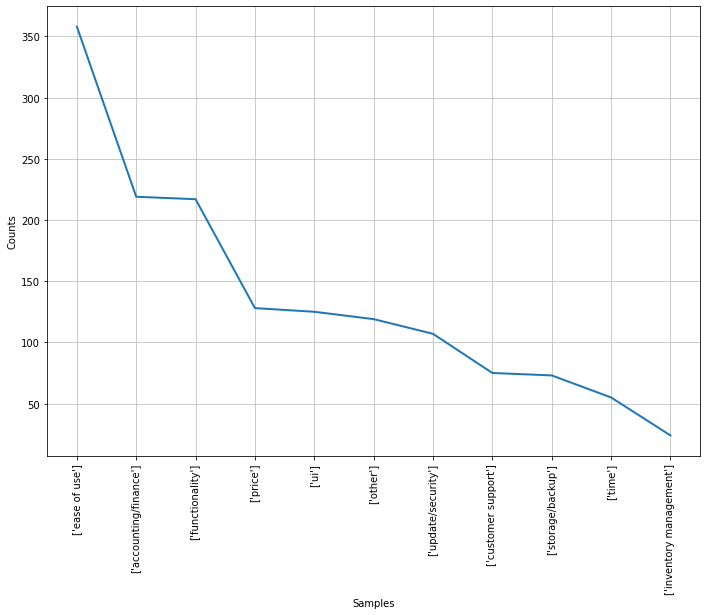

FreqDist({"['ease of use']": 358, "['accounting/finance']": 219, "['functionality']": 217, "['price']": 128, "['ui']": 125, "['other']": 119, "['update/security']": 107, "['customer support']": 75, "['storage/backup']": 73, "['time']": 55, "['inventory management']": 24})


In [10]:
level2_freq = FreqDist(aspect)
level2_freq.plot()
level2_freq.pprint(n_classes)

In [11]:
sentence = [util.clean_sentence(x) for x in sentence]

In [12]:
sentence[:3]

['tally supports export cs gst tax calculationreadable data available filling gst returns provide multi language support maintains inventory along accounts automatic interest calculation various accounts like receivable payable capital account user security controls along data safety features supports audit features useful presentation data bar charts provides profit loss financial year also provides various ratios analysis financial data available students learning purpose',
 'create account multiple companies use multiple windows need calculations hand everything percentage deductions calculated tally',
 'tally software user friendly say intuitive single user multiple user license multiuser licence access tally multiple devices computers laptops even remote facility give remote tally support also nice single user means silver license happy using accountant easily maintain purchase sale payment receipt invoice entries easy take data backup also']

max len =  137


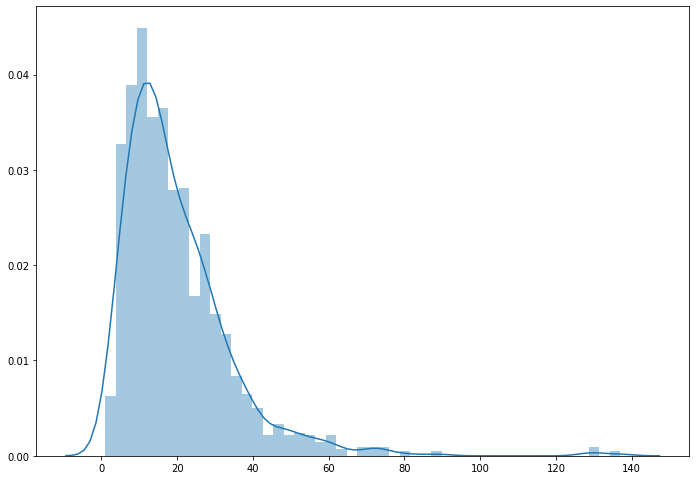

In [13]:
lengths = np.array([len(s.split()) for s in sentence])
print('max len = ',max(lengths))
sns.distplot(lengths)

In [14]:
max_list = [np.percentile(lengths, x) for x in range(75,100, 5)]

In [15]:
max_list

[26.0, 28.0, 32.0, 36.0, 46.0]

In [16]:
def define_model(learning_rate, dropout, lstm_out, n_hidden_layer, em, em_trainable_flag, free_em_dim, vocab_size, no_of_classes, max_length):
    model = Sequential()
    if em == 'free':
        model.add(Embedding(vocab_size, free_em_dim))
    else:
        model.add(Embedding(vocab_size, len(eval(em)[0]), weights=[eval(em)], input_length=max_length, trainable=em_trainable_flag))
    model.add(Bidirectional(LSTM(lstm_out, recurrent_dropout=dropout)))
    for i in range(n_hidden_layer):
        model.add(Dense(int((2*lstm_out+no_of_classes)/2), activation='relu'))
    model.add(Dense(no_of_classes, activation='softmax'))
    optimizer = Adam(lr=learning_rate)
    model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])
    print(model.summary())
    return model

In [17]:
def train_aspect_extraction(dataX, dataY, word2vec_model, tokenizer, n_classes, max_length, lr, epochs, lstm_out):
    first_iteration_flag = True
    trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.20, shuffle=True, 
                                                    stratify=dataY ,random_state=42)
    trainX = util.encode_text(tokenizer, trainX, max_length)
    testX = util.encode_text(tokenizer, testX, max_length)
    trainY, testY, lable_encoding = util.convert_lables(trainY,testY, n_classes)
    
    vocab_size = len(tokenizer.word_index) + 1
    with mlflow.start_run():
        model = define_model(learning_rate=lr, dropout=0.5,lstm_out=lstm_out, n_hidden_layer=1, 
                         em='embedding_matrix_word2vec', em_trainable_flag=False, free_em_dim=400, 
                                  vocab_size=vocab_size, no_of_classes= n_classes, max_length =max_length)
    
        start = time.time()
        history_object = model.fit(trainX, trainY, epochs=epochs, batch_size=16, verbose=0)
        run_time = (time.time()-start)/60
        train_loss = history_object.history['loss'][-1]
        train_accuracy = history_object.history['accuracy'][-1]
    
        pred = model.predict(testX)
        pred_class = np.argmax(pred, axis=1)
        
        #test_accuracy = ((testY == pred).sum())/len(testY)
        testY1 = to_categorical(testY, n_classes)
        score = model.evaluate(testX, testY1, verbose=0) 
        test_loss = score[0]
        test_accuracy = score[1]
        
        f1_w = f1_score(testY,pred_class,average='weighted')
        f1_m = f1_score(testY,pred_class,average='macro')
        
        
        mlflow.log_param("max_length", max_length)
        mlflow.log_param("lr", lr)
        mlflow.log_param('lstm_out', lstm_out)
        mlflow.log_metric("train_loss", train_loss)
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("test_loss", test_loss)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("f1_weighted", f1_w)
        mlflow.log_metric("f1_macro", f1_m)
        mlflow.log_metric('run_time_mins', run_time)

In [18]:
dataX = sentence
dataY = aspect
tokenizer = util.create_tokenizer(dataX)
max_length = 36
lr=0.00063
n_classes = 11
vocab_size1 = len(tokenizer.word_index) + 1
word2vec_model = util.load_word2vec('/home/mahesh/Downloads/GoogleNews-vectors-negative300.bin.gz')
embedding_matrix_word2vec = util.get_embedding_matrix(word2vec_model, tokenizer, vocab_size1, 300)
em = eval('embedding_matrix_word2vec')
print(len(em[0]))
        
train_aspect_extraction(dataX, dataY, word2vec_model, tokenizer, n_classes, max_length, lr, 100, 400)

300
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 36, 300)           817200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 800)               2243200   
_________________________________________________________________
dense_1 (Dense)              (None, 405)               324405    
_________________________________________________________________
dense_2 (Dense)              (None, 11)                4466      
Total params: 3,389,271
Trainable params: 2,572,071
Non-trainable params: 817,200
_________________________________________________________________
None


In [19]:
dataX = sentence
dataY = aspect
tokenizer = util.create_tokenizer(dataX)
max_length = 32
lr=0.00063
n_classes = 11
vocab_size1 = len(tokenizer.word_index) + 1
train_aspect_extraction(dataX, dataY, word2vec_model, tokenizer, n_classes, max_length, lr, 100, 400)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 300)           817200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 800)               2243200   
_________________________________________________________________
dense_3 (Dense)              (None, 405)               324405    
_________________________________________________________________
dense_4 (Dense)              (None, 11)                4466      
Total params: 3,389,271
Trainable params: 2,572,071
Non-trainable params: 817,200
_________________________________________________________________
None


In [20]:
for ml in [26, 28, 46]:
    train_aspect_extraction(dataX, dataY, word2vec_model, tokenizer, n_classes, ml, lr, 100, 400)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 26, 300)           817200    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 800)               2243200   
_________________________________________________________________
dense_5 (Dense)              (None, 405)               324405    
_________________________________________________________________
dense_6 (Dense)              (None, 11)                4466      
Total params: 3,389,271
Trainable params: 2,572,071
Non-trainable params: 817,200
_________________________________________________________________
None
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 28, 300)           817200    
___________

In [24]:
for ml in max_list:
    train_aspect_extraction(dataX, dataY, word2vec_model, tokenizer, n_classes, int(ml), 0.001, 100, 400)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 26, 300)           817200    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 800)               2243200   
_________________________________________________________________
dense_11 (Dense)             (None, 405)               324405    
_________________________________________________________________
dense_12 (Dense)             (None, 11)                4466      
Total params: 3,389,271
Trainable params: 2,572,071
Non-trainable params: 817,200
_________________________________________________________________
None
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 28, 300)           817200    
___________

In [23]:
max_list

[26.0, 28.0, 32.0, 36.0, 46.0]

In [18]:
dataX = sentence
dataY = aspect
max_length = 32
tokenizer = util.create_tokenizer(dataX)

lr=0.00063
n_classes = 11
vocab_size1 = len(tokenizer.word_index) + 1

trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.20, shuffle=True, 
                                                    stratify=dataY ,random_state=42)
trainX = util.encode_text(tokenizer, trainX, max_length)
testX = util.encode_text(tokenizer, testX, max_length)
trainY, testY, lable_encoding = util.convert_lables(trainY,testY, n_classes)

word2vec_model = util.load_word2vec('/home/mahesh/Downloads/GoogleNews-vectors-negative300.bin.gz')
embedding_matrix_word2vec = util.get_embedding_matrix(word2vec_model, tokenizer, vocab_size1, 300)


model = define_model(learning_rate=lr, dropout=0.5,lstm_out=400, n_hidden_layer=1, 
                         em='embedding_matrix_word2vec', em_trainable_flag=False, free_em_dim=400, 
                                  vocab_size=vocab_size1, no_of_classes= n_classes, max_length =max_length)
    
history_object = model.fit(trainX, trainY, epochs=100, batch_size=16, verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 300)           817200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 800)               2243200   
_________________________________________________________________
dense_1 (Dense)              (None, 405)               324405    
_________________________________________________________________
dense_2 (Dense)              (None, 11)                4466      
Total params: 3,389,271
Trainable params: 2,572,071
Non-trainable params: 817,200
_________________________________________________________________
None


In [19]:
pred = model.predict(testX)
pred_class = np.argmax(pred, axis=1)
        

In [22]:
testY

array([ 2,  0,  3,  5,  0,  3,  2,  5,  2,  1,  2,  7,  8,  2,  2,  9,  2,
        3,  2,  3,  2,  1, 10,  0,  2,  5,  7,  2,  6,  8,  2,  3,  3,  9,
        0,  2,  9,  5,  2,  3, 10,  2,  8,  3,  2,  5,  6,  8,  9,  3,  2,
        2,  0,  0,  0,  4,  1,  2,  6,  7,  0,  9,  1,  9,  6,  7,  4,  2,
        0,  6,  6,  3,  0,  4, 10,  3, 10,  2,  7,  3,  2,  6,  2,  3,  7,
        1,  0, 10,  0,  1,  5,  7, 10,  0,  9,  0,  0,  6,  0,  0,  9,  5,
        0,  7, 10,  9,  0,  1,  0,  0,  6,  0,  2,  7,  2,  0,  0,  3,  5,
       10,  0,  3,  9,  0,  2,  3,  0,  7,  2,  3,  2,  6,  2,  2,  2,  5,
        0,  5,  9,  0,  5,  2,  2,  7,  1,  0,  2,  2,  3,  2,  3,  7,  3,
        3,  2,  5,  2,  0,  0,  0,  5,  9,  2,  9,  3,  0,  7,  3,  6,  0,
        0,  2,  9, 10,  8,  2,  0,  8,  2,  6,  2,  6,  6,  3,  3,  5,  2,
        2,  2,  3,  9,  6,  2,  2,  9,  6,  6,  1,  3, 10,  3,  2, 10,  3,
        3,  3,  5,  4,  6, 10,  5,  3,  6,  3,  2,  9,  0, 10,  4,  5,  0,
        5,  6,  2,  9, 10

In [23]:
pred_class

array([ 2,  0,  3,  5,  0,  3, 10,  5,  2,  1,  0,  7,  8,  2,  2,  9,  2,
        3,  2,  3,  0,  1,  2, 10,  2,  5,  0,  2,  6,  8,  2,  2,  3,  9,
        5,  2,  9,  5, 10,  3, 10,  3,  8,  3,  2,  3,  6,  8,  9,  3,  2,
        2,  0,  0,  0,  4,  1,  2,  6,  7,  3, 10,  1, 10,  6,  8,  4,  2,
        0,  6,  6,  3,  0,  4, 10,  3, 10,  2,  7,  3,  2,  6,  5,  3, 10,
        1,  0, 10,  0,  1,  5,  7, 10,  0,  9,  0,  0,  6,  0,  2,  9,  5,
        0,  7, 10,  9,  0,  1,  0,  0,  6,  0,  2,  7,  2,  0,  0,  3,  5,
       10,  9,  3,  2,  0,  2,  3,  0,  7,  2,  3,  5,  6,  2,  2,  2,  5,
        5,  5,  9,  0,  5,  2,  6,  7,  1,  2,  2,  2,  3,  2,  3,  0,  3,
        3, 10,  5,  2,  0,  3,  5,  5,  9,  3,  2,  3,  0,  7,  3,  6,  2,
        0,  2,  9, 10,  8,  2,  0,  3,  2,  6,  2,  6,  6,  3,  3,  5,  2,
        2,  2,  3,  9,  6,  2,  2,  9,  6,  6,  1,  3, 10,  3,  2, 10,  3,
        3,  3,  5,  4,  6, 10,  3,  3,  6,  3,  2,  9,  0, 10,  4,  5,  9,
        5,  6,  2,  9, 10

In [34]:
lable_encoding[0]

"['accounting/finance']"

In [36]:
for i in range(11):
    print('-----'+str(lable_encoding[i]+'-----'))
    points = (testY==i).sum()
    acc=((pred_class==i) & (testY==i)).sum()/points
    print('No. of points :' +str(points))
    print('accuracy : '+str(acc))

-----['accounting/finance']-----
No. of points :44
accuracy : 0.7045454545454546
-----['customer support']-----
No. of points :15
accuracy : 1.0
-----['ease of use']-----
No. of points :72
accuracy : 0.8333333333333334
-----['functionality']-----
No. of points :43
accuracy : 0.9534883720930233
-----['inventory management']-----
No. of points :5
accuracy : 1.0
-----['other']-----
No. of points :24
accuracy : 0.9166666666666666
-----['price']-----
No. of points :25
accuracy : 1.0
-----['storage/backup']-----
No. of points :15
accuracy : 0.7333333333333333
-----['time']-----
No. of points :11
accuracy : 0.9090909090909091
-----['ui']-----
No. of points :25
accuracy : 0.84
-----['update/security']-----
No. of points :21
accuracy : 0.8571428571428571


In [38]:
model.save('../models/aspect_model_v2_32_0.00063.h5')